# Plot

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../nonresonant_ttbar/CMS_mtt')
from cms_top_20_001_Limits import read_HEPdata_SM,getSMLO,getKfactor

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps.get_cmap('RdYlBu')

In [2]:
recastDataloop = pd.read_pickle('../nonresonant_ttbar/CMS_mtt/pp2tt_formFactors_scan.pcl')
recastDataEFT = pd.read_pickle('../nonresonant_ttbar/CMS_mtt/pp2tt_eft_scan.pcl')

In [3]:
# ### Load CMS data
xsecsObs,covMatrix = read_HEPdata_SM(dataDir='../nonresonant_ttbar/CMS_mtt/data')
# ### Load SM prediction (LO)
smLO = getSMLO(filename='../nonresonant_ttbar/CMS_mtt/sm/mtt_SM_ttbar_nnpdf4p0.txt')
# ### Load k-factors
kfac = getKfactor(filename='../nonresonant_ttbar/CMS_mtt/sm/kfac_nnlo_lo_highstats.txt')
# ### Leptonic BR
sm = kfac*smLO

In [4]:
### Select model point
modelFilter = {'mST' : 500, 'mChi' : 400, 'yDM' : 1.0}
# modelFilter = {'mST' : 500, 'mChi' : 475., 'yDM' : 1.0}
dfModelloop = recastDataloop.loc[(recastDataloop[list(modelFilter)] == pd.Series(modelFilter)).all(axis=1)]
dfModelEFT = recastDataEFT.loc[(recastDataEFT[list(modelFilter)] == pd.Series(modelFilter)).all(axis=1)]

# modelFilter = {'mST' : 600, 'mChi' : 500, 'yDM' : 1.0}
# dfModelEFT = recastDataloop.loc[(recastDataloop[list(modelFilter)] == pd.Series(modelFilter)).all(axis=1)]
print(len(dfModelloop),len(dfModelEFT))

1 1


In [5]:
# Get signal bins:
binCols = [c for c in dfModelloop.columns 
            if 'bin_' in c.lower() and not 'error' in c.lower()]
bins_left = np.array([eval(c.split('_')[1]) for c in binCols])
bins_right = np.array([eval(c.split('_')[2]) for c in binCols])
cms_bins = np.append(bins_left,bins_right[-1])

In [6]:
pt = dfModelloop.iloc[0]
signalLoop = list(zip(bins_left,pt[binCols].values))
signalLoop = np.array(sorted(signalLoop))[:,1]
yDM = pt['yDM']
# Make sure signal is normalized to yDM = 1
signalLoop = signalLoop/yDM**2
# Rescale predictions by bin-dependent k-factors 
# and leptonic BR
signalLoop = kfac*signalLoop

pt = dfModelEFT.iloc[0]
signalEFT = list(zip(bins_left,pt[binCols].values))
signalEFT = np.array(sorted(signalEFT))[:,1]
yDM = pt['yDM']
# Make sure signal is normalized to yDM = 1
signalEFT = signalEFT/yDM**2
# Rescale predictions by bin-dependent k-factors 
# and leptonic BR
signalEFT = kfac*signalEFT

In [7]:
signalLoop = signalLoop/(bins_right-bins_left)
signalEFT = signalEFT/(bins_right-bins_left)
sm = sm/(bins_right-bins_left)

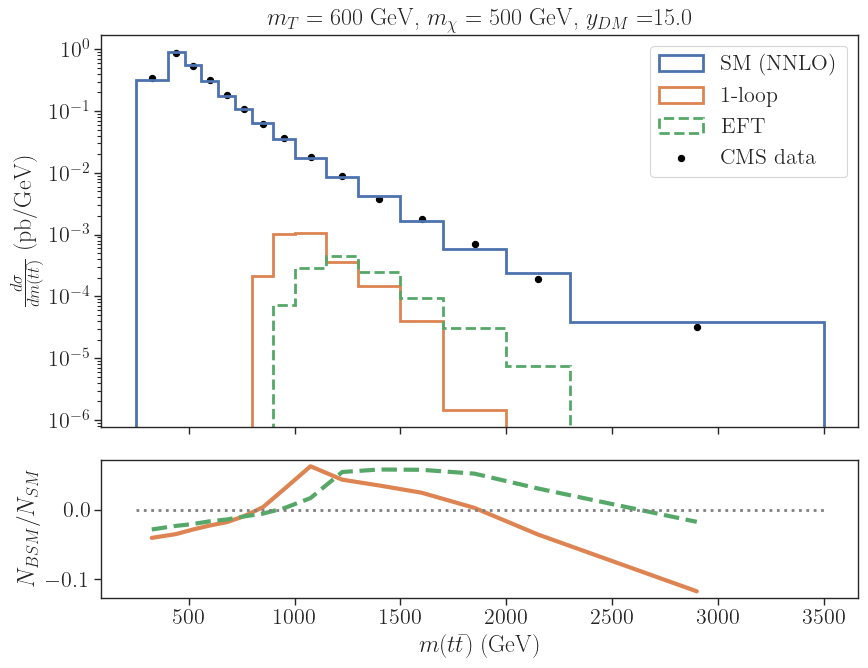

In [8]:
yDM = 15.0
# Define colors
colors = sns.color_palette('deep')[:3]
_, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 0.7]},figsize=(9,7))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)

axarr[0].hist(bins_left,bins=cms_bins,weights=sm,label='SM (NNLO)',histtype='step',color=[colors[0]],linewidth=2.0)
axarr[0].hist(bins_left,bins=cms_bins,weights=signalLoop*(yDM**2),label=r'1-loop',
                      histtype='step',linewidth=2,color=[colors[1]])
axarr[0].hist(bins_left,bins=cms_bins,weights=signalEFT*(yDM**2),label=r'EFT',
                     histtype='step',linewidth=2,linestyle='dashed',color=[colors[2]])
axarr[0].scatter((bins_right+bins_left)/2.,xsecsObs,s=20,label='CMS data',c='black')
axarr[0].set_yscale('log')
axarr[0].legend()


ratioLoop = np.divide(signalLoop*(yDM**2), sm)
ratioEFT = np.divide(signalEFT*(yDM**2), sm)
axarr[1].plot((bins_left+bins_right)/2.,ratioLoop,linewidth=3.0,linestyle='-',c=colors[1])
axarr[1].plot((bins_left+bins_right)/2.,ratioEFT,linewidth=3.0,linestyle='--',c=colors[2])
axarr[1].hlines(y=0.0,xmin=bins_left.min(),xmax=bins_right.max(),linestyle='dotted',color='gray',linewidth=2)


axarr[1].set_xlabel(r'$m(t\bar{t})$ (GeV)')
axarr[1].set_ylabel(r'$N_{BSM}/N_{SM}$')
axarr[0].set_ylabel(r'$\frac{d \sigma}{d m(t\bar{t})}$ (pb/GeV)')
axarr[0].set_title(r'$m_{T} = %1.0f$ GeV, $m_{\chi} = %1.0f$ GeV, $y_{DM} = $%1.1f' %(modelFilter['mST'],modelFilter['mChi'],yDM))
plt.tight_layout()
plt.savefig('mtt_dist_mST_%1.0f_mChi_%1.0f_yDM_%1.0f.png' %(modelFilter['mST'],modelFilter['mChi'],yDM))
plt.show()